In [71]:
# This is Final Exam for IBM Time Series course.
# I use monthly vw market data.

In [2]:
!pip install statsmodels==0.11.0
!pip install pmdarima

     |████████████████████████████████| 8.7 MB 803 kB/s            
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.19.0 requires statsmodels>=0.13, but you have statsmodels 0.11.0 which is incompatible.
plotnine 0.8.0 requires statsmodels>=0.12.1, but you have statsmodels 0.11.0 which is incompatible.
     |████████████████████████████████| 1.4 MB 772 kB/s            


In [3]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
plt.style.use('seaborn-white')
from datetime import datetime
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore')
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print(sm.__version__)

0.11.0


In [4]:
path = '../input/monthly-market-returns/mMKT.CSV'
df = pd.read_csv(path)
df.shape

(1146, 2)

In [5]:
df.head()

,date,mkt
0,192607,2.96
1,192608,2.64
2,192609,0.36
3,192610,-3.24
4,192611,2.53


In [6]:
df.date=pd.to_datetime(df.date,format='%Y%m')
df.date=df.date.dt.strftime("%Y-%m")

In [7]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1146 entries, 1926-07 to 2021-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mkt     1146 non-null   float64
dtypes: float64(1)
memory usage: 17.9+ KB


<AxesSubplot:xlabel='date', ylabel='mkt'>

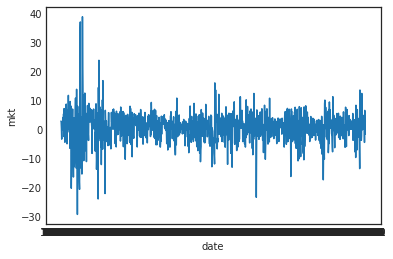

In [8]:
df.describe()
sns.lineplot(x=df.index, y='mkt', data=df)

In [9]:
# testing stationarity and seasonality
import statsmodels.tsa.stattools as ts

results = ts.adfuller(df)
results
# ts is stationary.

(-8.299754730569054,
 4.0482698873981886e-13,
 20,
 1125,
 {'1%': -3.4361760299117914,
  '5%': -2.8641125290596436,
  '10%': -2.5681396861234567},
 6931.732739371823)

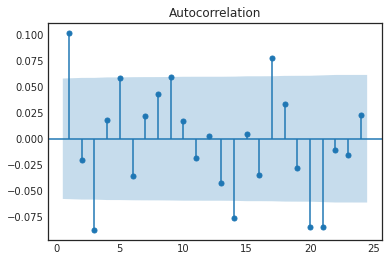

In [10]:
# forecasting using ARIMA

# first, see acf/pacf

sm.tsa.graphics.plot_acf(df.mkt, lags=24, zero=False);

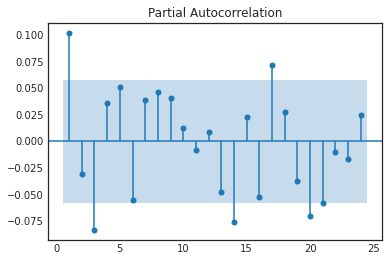

In [11]:
sm.tsa.graphics.plot_pacf(df.mkt, lags=24, zero=False);

In [12]:
# acf and pacf look like noise, not sure which arma to use.

from pmdarima.arima import auto_arima

train = df[0:900]
test = df[900:]

In [13]:
# try to autodetect arima order, use this: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

arima_model = auto_arima(train, start_p=0, start_q=1, d=0, max_p=12, max_d=0, max_q=12, seasonal=False, n_fits=50, steepwise=False)
arima_model

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

In [14]:
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

predictions = []
actual = []

#len(df.mkt)

for i in np.arange(10, len(df.mkt)):
    arima_model = ARIMA(df.mkt[0:i], order=(0,0,1))
    arima_model_fit = arima_model.fit(disp=0)
    yhat = arima_model_fit.forecast()
    predictions.append(yhat[0])
    actual.append(df.mkt[i])
    
warnings.resetwarnings()


In [15]:
predictions = np.concatenate(predictions, axis=0)
print(predictions[0:10])
print(actual[0:10])
np.mean((actual-predictions)**2)
np.mean((actual-predictions)**2)

[ 1.18563637 -1.95104892  1.82153845 -2.9247033   0.46906629  0.72884522
  3.60994473  0.29170408  0.98692448  2.59155854]
[5.44, -2.34, 7.26, 1.97, 4.76, -4.31, 6.58, 2.09, -0.68, -1.7]


29.039041391689338

In [44]:
print(len(predictions))
print(len(actual))
print(np.mean((actual-predictions)**2))
print(np.mean((actual-np.full((len(actual)), 8))**2))

1136
1136
29.039041391689338
82.11143248239436


In [17]:
# define functions, needed for RNN forecasting

def get_keras_format_series(series):
    """Convert a series to a numpy array of shape [n_obs, time_steps, features]"""
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, input_periods, test_periods):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = df[series_name]
    train = forecast_series[:-test_periods] 
    test = forecast_series[-test_periods:] 

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_periods): 
        train_X.append(train[i:i+input_periods]) # each training sample is of length input hours
        train_y.append(train[i+input_periods]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_periods] 
    test_y = test[input_periods:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [18]:
# forecasting using RNN

train_X, test_X_init, train_y, test_y = get_train_test_data(df, 'mkt', 12, 24)
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (1110, 12, 1)
Training output shape: (1110,)
Test input shape: (12,)
Test output shape: (12,)


In [19]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [38]:
model_rnn = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=300)
# model.summary()

In [21]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    #X_init = X_init.copy().reshape(1,-1,1)
    #X_init = np.array(X_init)
    X_init = np.array(test_X_init.copy())
    X_init = X_init.reshape(1,12,1)

    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], 24)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

In [22]:
tX = np.array(test_X_init.copy())
tX=tX.reshape(1,12,1)
tX.shape

(1, 12, 1)

In [23]:
model_rnn.predict(np.array(tX))

array([[0.5544177]], dtype=float32)

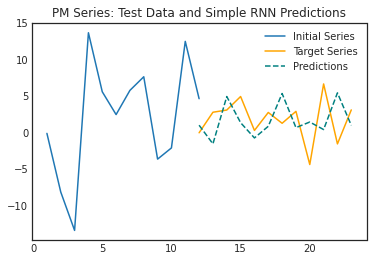

In [40]:
#predict(test_X_init, 12, model_rnn)
predict_and_plot(test_X_init, test_y, model_rnn, 'PM Series: Test Data and Simple RNN Predictions')

In [41]:
predictions_rnn = predict(test_X_init, 12, model_rnn)
print(predictions_rnn)
print(test_y)
print(np.mean((np.array(test_y)-predictions_rnn)**2))
print(np.mean((np.array(test_y)-0.5)**2))

[[ 1.0064443 ]
 [-1.5437542 ]
 [ 4.9266157 ]
 [ 1.3523735 ]
 [-0.732533  ]
 [ 0.8580749 ]
 [ 5.3391433 ]
 [ 0.678347  ]
 [ 1.4409504 ]
 [ 0.41198346]
 [ 5.4288425 ]
 [ 0.98707926]]
date
2021-01   -0.03
2021-02    2.78
2021-03    3.08
2021-04    4.93
2021-05    0.29
2021-06    2.75
2021-07    1.27
2021-08    2.90
2021-09   -4.37
2021-10    6.65
2021-11   -1.55
2021-12    3.10
Name: mkt, dtype: float64
12.810513690123663
9.643500000000001


In [ ]:
# forecasting using LSTM



In [42]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [ ]:
model_lstm = fit_LSTM(train_X, train_y, cell_units=30, epochs=1000) 

predict_and_plot(test_X_init, test_y, model_lstm, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

predictions_lstm = predict(test_X_init, 12, model_lstm)
#print(predictions_rnn)
#print(test_y)
print(np.mean((np.array(test_y)-predictions_lstm)**2))
print(np.mean((np.array(test_y)-0.5)**2))

In [ ]:
# forecasting using transformer?